In [1]:

from pathlib import Path
from h5py import File
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import display
import json
import wandb
pd.options.plotting.backend = "plotly"

## Acquisition des données

In [2]:
config = {
    "dataset_path": "dataset_250pts_40ksamples.hdf5",
    "num_pts": 250,
}
dataset_path = Path('../../data/'+config["dataset_path"])
final_assignements = {}
init_assignements = {}
metadata = {}
points_coords = {}
with File(dataset_path) as cache:
    for k,v in cache["final_assignements"].items():
        final_assignements[k] = np.copy(v)
    for k,v in cache["init_assignements"].items():
        init_assignements[k] = np.copy(v)
    for k,v in cache["metadata"].items():
        arr = np.copy(v)
        metadata[k] = {"SEED": arr[0], "NUM_CLUST": arr[1], "NUM_POINTS": arr[2], 
                       "INIT_CHOICE": arr[3], 
                       "IMPR_CLASS": arr[4], 
                       "IT_ORDER": arr[5], 
                       "init_cost": arr[6], "final_cost": arr[7], "num_iter": arr[8], "num_iter_glob": arr[9], "duration": arr[10],"dataset_key":k}
    for k,v in cache["points_coords"].items():
        points_coords[k] = np.copy(v)
df_number = pd.DataFrame(list(metadata.values()))
df = df_number.copy()
df.loc[df["INIT_CHOICE"] == 0,"INIT_CHOICE"] = "random"
df.loc[df["INIT_CHOICE"] == 1,"INIT_CHOICE"] = "kmeans+"
df.loc[df["IMPR_CLASS"] == 0,"IMPR_CLASS"] = "BI"
df.loc[df["IMPR_CLASS"] == 1,"IMPR_CLASS"] = "FI"
df.loc[df["IT_ORDER"] == 0,"IT_ORDER"] = "BACK"
df.loc[df["IT_ORDER"] != 0,"IT_ORDER"] = "other"
df_src = df.copy()

## Initialisation de wandb (où seront stockées les figures)

In [76]:
run = wandb.init(
                config=config,
                project="Recherche Maitrise",  # Title of your project
                group="Dataset statistics",  # In what group of runs do you want this run to be in?
                name=f"Base dataset source points", 
                tags=["dataset", "diversified_dataset"],
                save_code=True,
                entity="romo-1245",
            )

## Statistiques générales 

In [3]:
df_sel = df_number.query("NUM_CLUST == 2")
for col in df_sel.columns:  
    fig = px.histogram(df_sel, x=col, nbins=100)
    run.log({"stats_"+col:fig})
run.log({"num_unique_SEED":len(df_sel["SEED"].unique()),"num_samples":len(df_sel)})

## Statistiques par catégorie

In [4]:

df["category"] = df["IMPR_CLASS"].astype(str)+"_"+df["INIT_CHOICE"].astype(str)
for num_clust in df["NUM_CLUST"].unique():
    df_tmp = df.query(f"NUM_CLUST == {num_clust}")
    for attr in ["init_cost","num_iter","num_iter_glob","duration","final_cost"]:
        fig = px.histogram(df_tmp,x=attr,color="category",nbins=1000,barmode="overlay",)    
        run.log({"hist_categories_"+attr+"_"+str(num_clust):fig})

## Comparaison FI BI pour même nuage de point

In [5]:
df_cpy = df.copy()
try:
    df_cpy.drop(columns=["category"],inplace=True)
except KeyError:
    pass
df_orig = df_cpy.copy()
df_cpy.loc[df_cpy["IT_ORDER"]=="BACK","IT_ORDER"] = 0
df_cpy.loc[df_cpy["IT_ORDER"]=="other","IT_ORDER"] = -1
df_cpy.loc[df_cpy["INIT_CHOICE"]=="random","INIT_CHOICE"] = 0
df_cpy.loc[df_cpy["INIT_CHOICE"]=="kmeans+","INIT_CHOICE"] = 1
Ldf = []
for impr in ["FI","BI"]:
    df_impr = df_cpy.query(f"IMPR_CLASS == \'{impr}\'")
    df_impr = df_impr.drop(columns=["IMPR_CLASS","dataset_key"])
    df_impr.set_index("SEED",inplace=True)
    Ldf.append(df_impr)
new_df = (Ldf[0]-Ldf[1])
df_infos = df_orig.copy().query("IMPR_CLASS=='BI'").set_index("SEED")
for k in ["init_cost",attr,"num_iter","num_iter_glob","duration"]:
    df_infos[k] = new_df[k]
df_infos.reset_index(inplace=True)
display(df_infos)

,SEED,NUM_CLUST,NUM_POINTS,INIT_CHOICE,IMPR_CLASS,IT_ORDER,init_cost,final_cost,num_iter,num_iter_glob,duration,dataset_key
0,0.0,2.0,250.0,random,BI,other,0.0,8.731149e-11,30.0,-12063.0,-415.0,"0,0,2,0,0"
1,1.0,2.0,250.0,kmeans+,BI,other,0.0,1.164153e-10,0.0,-3057.0,-77.0,"1,0,2,1,0"
2,10.0,2.0,250.0,kmeans+,BI,other,0.0,-1.746230e-10,0.0,-3730.0,-73.0,"10,0,2,1,0"
3,100.0,2.0,250.0,random,BI,other,0.0,5.491090e+01,74.0,-12212.0,-217.0,"100,0,2,0,0"
4,1000.0,2.0,250.0,kmeans+,BI,other,0.0,5.820766e-11,4.0,-8576.0,-169.0,"1000,0,2,1,0"
...,...,...,...,...,...,...,...,...,...,...,...,...
79995,9995.0,2.0,250.0,kmeans+,BI,other,0.0,1.222539e+04,7.0,-12367.0,-275.0,"9995,0,2,1,0"
79996,9996.0,2.0,250.0,random,BI,other,0.0,-2.567337e+02,112.0,-6356.0,-147.0,"9996,0,2,0,0"
79997,9997.0,2.0,250.0,kmeans+,BI,other,0.0,-1.746230e-10,2.0,-4003.0,-150.0,"9997,0,2,1,0"
79998,9998.0,2.0,250.0,kmeans+,BI,other,0.0,-5.820766e-11,2.0,-9096.0,-121.0,"9998,0,2,1,0"


Affichage de la différence FI-BI

In [6]:
for num_clust in [2]:
    df_tmp = df_infos.query(f"NUM_CLUST == {num_clust}")
    for attr in ["init_cost","num_iter","num_iter_glob","duration","final_cost"]:
       df_rand = df_tmp.query(f"INIT_CHOICE == \'random\'")
       df_kmeans = df_tmp.query(f"INIT_CHOICE == \'kmeans+\'")
       fig = px.histogram(df_tmp,x=attr,color="INIT_CHOICE",
                     color_discrete_map = {'random':'blue','kmeans+':'red'},
                     histnorm="percent",
                     range_y=None,
                     barmode="overlay",
                     nbins=500,title="FI-BI (mean in dotted line) "+ f"Mean random:{df_rand[attr].mean():.2f} ; "+f"Mean kmeans+:{df_kmeans[attr].mean():.2f}")  
       fig.add_vline(x=df_rand[attr].mean(),
              line=dict(dash= 'dot',color='blue')
              )
       fig.add_vline(x=df_kmeans[attr].mean(),
              line=dict(dash= 'dot',color='red')
              )
       run.log({"hist_FI-BI_"+attr+"_"+str(num_clust):fig})

## Calcul de l'algorithme le plus performant

In [ ]:

dico_backup_best = {}
dico_backup_diff = {}

for attr in ["final_cost"]:
   if attr not in dico_backup_best:
      dico_backup_best[attr] = {}
   if attr not in dico_backup_diff:
      dico_backup_diff[attr] = {}
   for num_clust in [2]:
      df_tmp = df_infos.query(f"NUM_CLUST == {num_clust}")
      if num_clust not in dico_backup_diff[attr]:
         dico_backup_diff[attr][num_clust] = {}
      for index, row in df_tmp.iterrows():
         dico_backup_diff[attr][num_clust][row["dataset_key"]] = row[attr]
      df_tmpcpy = df_tmp.copy()
      df_tmp.loc[df_tmpcpy[attr] > 0,attr] = "BI"
      df_tmp.loc[df_tmpcpy[attr] < 0,attr] = "FI"
      df_tmp.loc[df_tmpcpy[attr] == 0,attr] = "Equal"
      if num_clust not in dico_backup_best[attr]:
         dico_backup_best[attr][num_clust] = {}
      for index, row in df_tmp.iterrows():
         dico_backup_best[attr][num_clust][row["dataset_key"]] = row[attr]
      fig = px.histogram(df_tmp,x=attr,color="INIT_CHOICE",
                              range_y=None, 
                              barmode="overlay",
                              nbins=500,title="Suggestions")
      run.log({"hist_suggestions_"+attr+"_"+str(num_clust):fig})
with open(str(dataset_path.parent / f'./dico_best.json'), 'w') as fp:
   json.dump(dico_backup_best, fp,indent=4)
with open(str(dataset_path.parent / f'./dico_diff.json'), 'w') as fp:
   json.dump(dico_backup_diff, fp,indent=4)
run.finish()


## Affichage des images générées par le script points_to_images

In [8]:
import matplotlib.pyplot as plt
from h5py import File
from pathlib import Path
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
[0. 1. 2.]


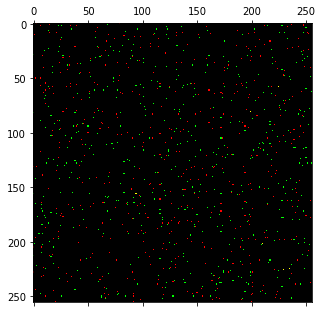

In [17]:

with File(str(Path("../../data/image_dataset/dataset_ia_2_clusters_250pts_grid_256px_tr.hdf5").resolve()),"r") as f:
    k = list(f["input"].keys())[0]
    array = np.copy(f["input"][k])
shape = (*array.shape[:2],1)
zeros = np.zeros(shape)
array = np.concatenate((array,zeros),axis=-1)
print(array.shape)
print(np.unique(array))
fig = plt.figure(figsize=(5,5))
plt.matshow(array, fignum=1)

## Statistiques d'intensité de pixels sur tout le dataset

In [9]:
df = df_src.copy().query("NUM_CLUST == 2 & IMPR_CLASS == 'BI'")
df.sort_values(by=['dataset_key'],inplace=True)
for grid in [64,128,256]:
    dico_clust_overlap = {}
    for dataset in ["tr","val"]:
        with File(str(Path(f"../../data/image_dataset/dataset_ia_2_clusters_250pts_grid_{grid}px_{dataset}.hdf5").resolve()),"r") as f:
            for k in f["input"]:
                dico_clust_overlap[k] = np.max(np.copy(f["input"][k]))
            
    elements = [dico_clust_overlap[k] for k in sorted(list(dico_clust_overlap.keys()))]
    df[f"grid_{grid}px_overlap"] = elements


In [ ]:
cols = [*[f"grid_{grid}px_overlap" for grid in [64,128,256]]]
print("Min")
df_aggr=df[cols].copy().min() 
display(df_aggr)
print("Mean")
df_aggr=df[cols].copy().mean()
display(df_aggr)
print("Max")
df_aggr=df[cols].copy().max()
display(df_aggr)
print(len(df))
